### Задание 1: составить словари для классификации по тональности.

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    - тест на определение ближайших слов
    - тест на аналогии (мужчина – король : женщина – королева)
    - тест на определение лишнего слова.
4. Постройте несколько визуализаций:
    - TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    - задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [162]:
import json
import bz2
import regex
import pickle
from scipy import sparse
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from collections import Counter
from itertools import chain
from pymorphy3 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import regex as re
import networkx as nx

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# чтение архива данных
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

df = pd.DataFrame(responses)

201030it [00:41, 4894.35it/s]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [4]:
# функции предобработки текста

# формируем словарь стоп-слов
mystopwords = stopwords.words('russian') + [
              'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
              'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', 'руб', 'г', 'го', 'ого', 'аж' 'всё', 'ешё']

# убераем пунктуацию    
def words_only(text: str) -> str:
    return " ".join(re.compile("[А-Яа-яЁё]+").findall(text))

# приводим слова к нормальной форме
def lemmatize(text: str, m=MorphAnalyzer()) -> list[str]:
    try:
        return [m.parse(word)[0].normal_form for word in text.split(' ')]
    except:
        pass

# исключаем стоп-слова    
def remove_stopwords(text: list[str], stopwords=mystopwords) -> list[str]:
    try:
        return [token for token in text if not token in stopwords]
    except:
        pass
    
# основная функция
def preprocess(text: str) -> list[list[str]]:
    sentences = nltk.tokenize.sent_tokenize(text) # делим на предложения
    return [remove_stopwords(lemmatize(words_only(sentence.lower()))) for sentence in sentences] # сборка всех функций 

In [5]:
df['text_pp'] = df['text'].progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [1:54:36<00:00, 22.32it/s]


In [6]:
%%time
corpus_sentences = list(itertools.chain(*df['text_pp']))

CPU times: total: 141 ms
Wall time: 139 ms


In [34]:
# сохранение копуса предложений
with open('corpus_sentences.pkl', 'wb') as file:
    pickle.dump(corpus_sentences, file)

In [ ]:
# загрузка копуса предложений
with open('corpus_sentences.pkl', 'rb') as file:    
    corpus_sentences = pickle.load(file)

In [7]:
%%time
w2v_model = Word2Vec(corpus_sentences, workers=4, vector_size=300, min_count=5, window=7, epochs=15)

CPU times: total: 14min 8s
Wall time: 3min 41s


In [8]:
# сохранение модели
w2v_model.save('banki_responses_model')

In [2]:
# загрузка модели
w2v_model = Word2Vec.load('banki_responses_model')

In [4]:
# выведем первые 10 слов словаря модели
for i, w in enumerate(w2v_model.wv.index_to_key):
    if i == 10:
        break
    print(i, w)

0 банк
1 карта
2 деньга
3 день
4 кредит
5 отделение
6 счёт
7 клиент
8 сотрудник
9 сказать


#### Стандартные тесты

In [10]:
# тесты на ближайшие слова
w2v_model.wv.most_similar('приветливый')[:3]

[('доброжелательный', 0.8048996329307556),
 ('улыбчивый', 0.7643572688102722),
 ('дружелюбный', 0.7608210444450378)]

In [11]:
w2v_model.wv.most_similar('хороший')[:3]

[('плохой', 0.6773030757904053),
 ('неплохой', 0.6188951730728149),
 ('отличный', 0.601102888584137)]

In [12]:
# тесты на аналогию
w2v_model.wv.most_similar(positive=['кредит', 'недвижимость'])[0]

('ипотека', 0.7267664074897766)

In [13]:
w2v_model.wv.most_similar(positive=['клиент'], negative=['юрлицо'])

[('вкладчик', 0.3734685182571411),
 ('заёмщик', 0.35259395837783813),
 ('проявление', 0.3474310338497162),
 ('проявлять', 0.33475083112716675),
 ('пользователь', 0.3235209882259369),
 ('отталкивать', 0.296891987323761),
 ('чрезмерный', 0.2945472002029419),
 ('персона', 0.2898469865322113),
 ('предсказуемость', 0.2887600362300873),
 ('поступок', 0.2878899872303009)]

In [14]:
# тесты на определение лишнего слова
w2v_model.wv.doesnt_match(['кредит', 'вклад', 'росспотребнадзор'])

'росспотребнадзор'

In [15]:
w2v_model.wv.doesnt_match(['сотрудник', 'физлицо', 'клиент'])

'сотрудник'

In [25]:
w2v_model.wv.doesnt_match(['приятный', 'благоприятный', 'неприятный'])

'благоприятный'

#### Визуализация

In [19]:
%%time
corpus_words = list(itertools.chain(*corpus_sentences))

CPU times: total: 1.11 s
Wall time: 1.11 s


In [29]:
# сохранение копуса слов
with open('corpus_words.pkl', 'wb') as file:
    pickle.dump(corpus_words, file)

In [3]:
# загрузка копуса слов
with open('corpus_words.pkl', 'rb') as file:    
    corpus_words = pickle.load(file)

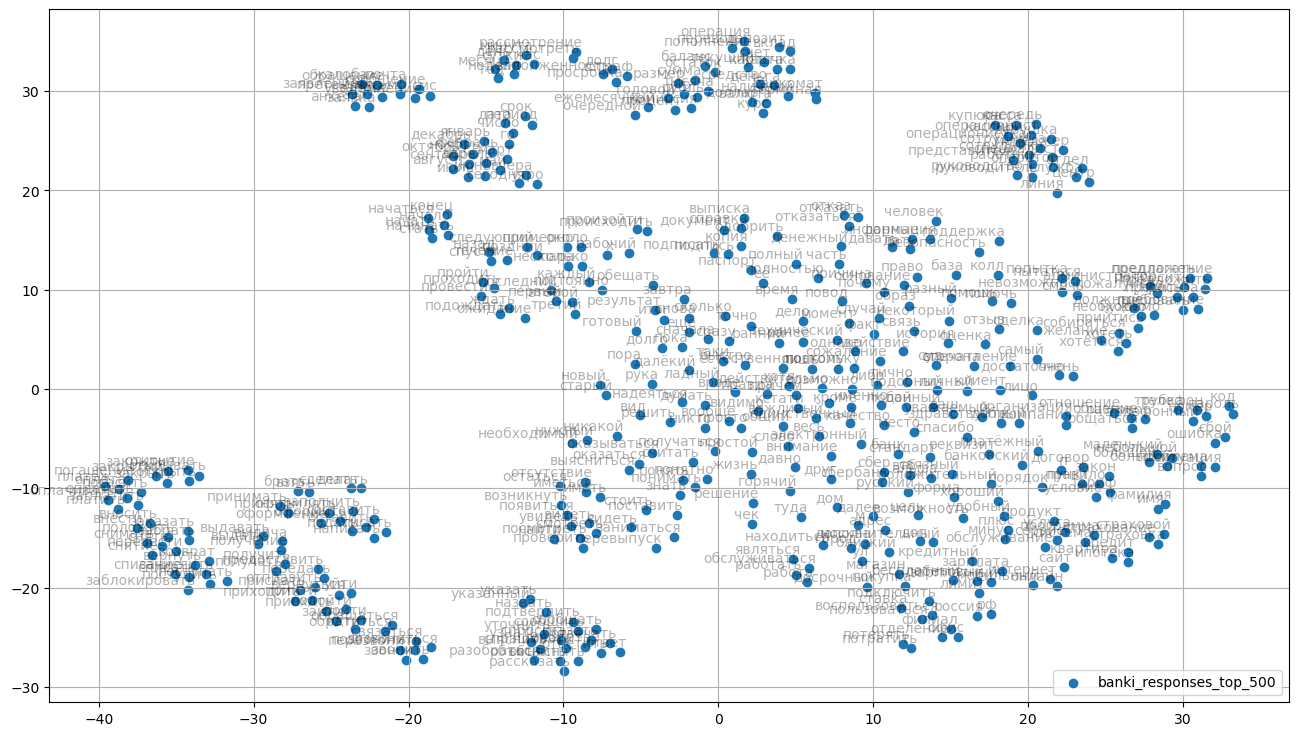

In [28]:
words = []
embeddings = []

for word in Counter(corpus_words).most_common(500):
    embeddings.append(w2v_model.wv[word[0]])
    words.append(word[0])

tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=5000, random_state=42)
tsne_embeddings = tsne_model.fit_transform(np.array(embeddings))
tsne_embeddings = tsne_model.fit_transform(np.array(tsne_embeddings))

def tsne_plot(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, alpha=a, label=label) 
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot('banki_responses_top_500', tsne_embeddings, words)

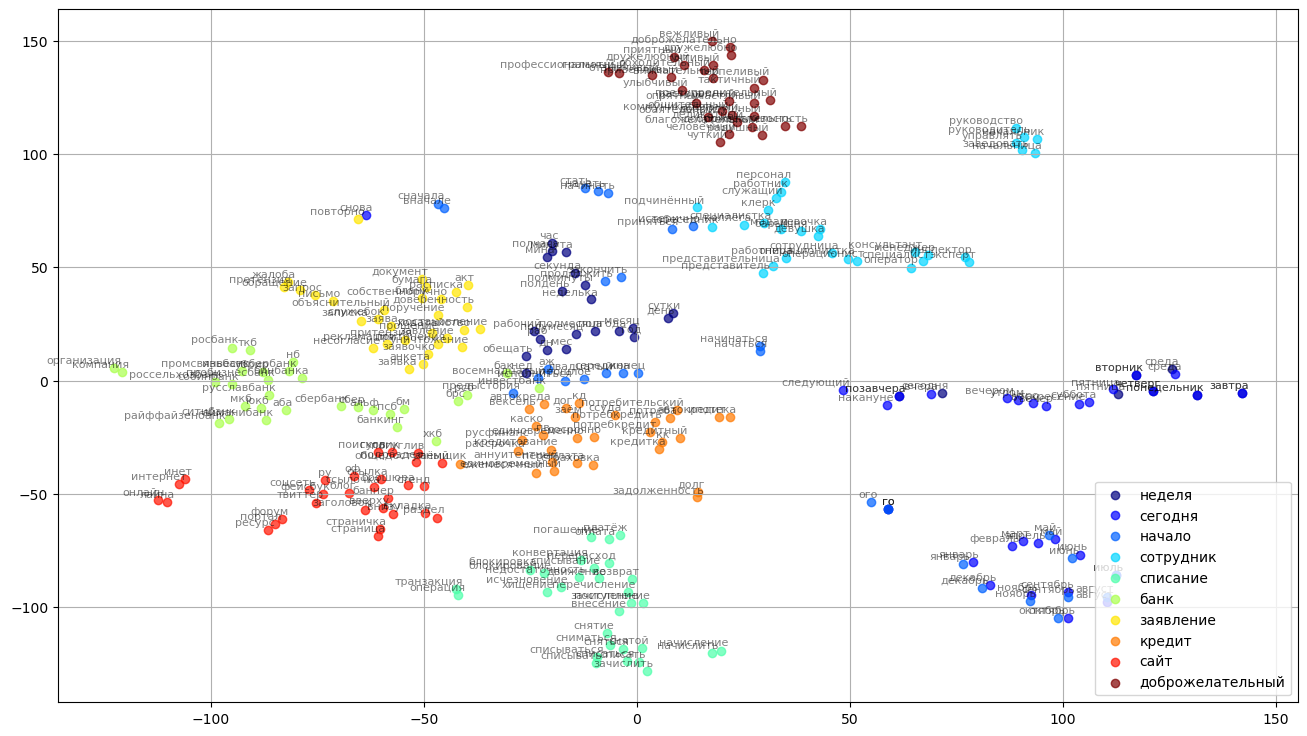

In [39]:
keys = ['неделя', 'сегодня', 'начало', 'сотрудник', 'списание', 'банк', 'заявление', 'кредит', 'сайт', 'доброжелательный']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=3500, random_state=42)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)   

def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.jet(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color.reshape(1,-1), alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

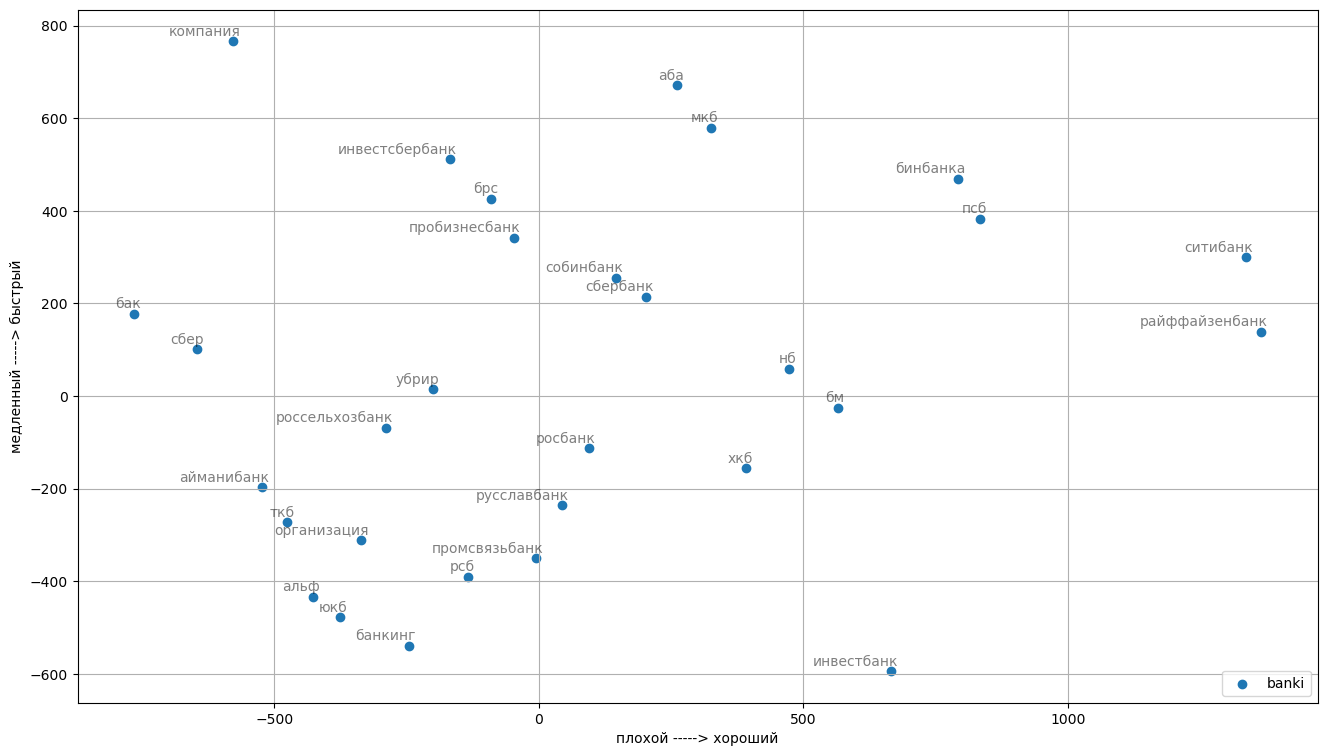

In [88]:
words = [w for w, _ in w2v_model.wv.most_similar('банк', topn=30)]
embeddings_x = []
embeddings_y = []

x = w2v_model.wv['хороший'] - w2v_model.wv['плохой']
y = w2v_model.wv['быстрый'] - w2v_model.wv['медленный']


for word in words:
    embeddings_x.append(w2v_model.wv[word] * x)
    embeddings_y.append(w2v_model.wv[word] * y)

tsne_model_x = TSNE(perplexity=1, n_components=1, init='pca', n_iter=5000, random_state=42)
tsne_embeddings_x = tsne_model_x.fit_transform(np.array(embeddings_x))

tsne_model_y = TSNE(perplexity=1, n_components=1, init='pca', n_iter=5000, random_state=42)
tsne_embeddings_y = tsne_model_y.fit_transform(np.array(embeddings_y))

def tsne_plot(label, embeddings_x, embeddings_y, words=[], a=1):
    plt.figure(figsize=(16, 9))
    x = embeddings_x
    y = embeddings_y
    plt.scatter(x, y, alpha=a, label=label) 
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.xlabel('плохой -----> хороший')
    plt.ylabel('медленный -----> быстрый')
    plt.show()

tsne_plot('banki', tsne_embeddings_x, tsne_embeddings_y, words)

### Часть 2. Распространение метки
Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8 негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в вершине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. `graphlab.label_propagation` (`graphlab` доступен бесплатно по образовательной лицензии)
2. `sklearn.semi_supervised.LabelPropagation`
3. `sklearn.semi_supervised.LabelSpreading`

Библиотека для работы с графами https://networkx.org/

In [115]:
# заготовка под оценочный словарь
poz_words = ['быстрый', 'удобный', 'доброжелательный', 'приветливый', 'надёжно'] # tag 1
neg_words = ['очередь', 'медленно', 'грубый', 'дорого', 'тесно']  # tag -1

# похожие слова без метки
unknown_words = set([w for word in poz_words + neg_words for w, _ in w2v_model.wv.most_similar(word, topn=5) if w not in poz_words + neg_words])

In [116]:
# инициализация пустого графа
G = nx.Graph()

# добавление вершин
G.add_nodes_from(poz_words + neg_words + list(unknown_words))

# добавление ребер
for word in list(G.nodes):
    similar_words = w2v_model.wv.most_similar(word, topn=20) # найдем похожие слова
    for sim_word, sim_val in similar_words:
        if sim_word not in list(G.nodes):
            continue
        G.add_edge(word, sim_word, weight=sim_val)

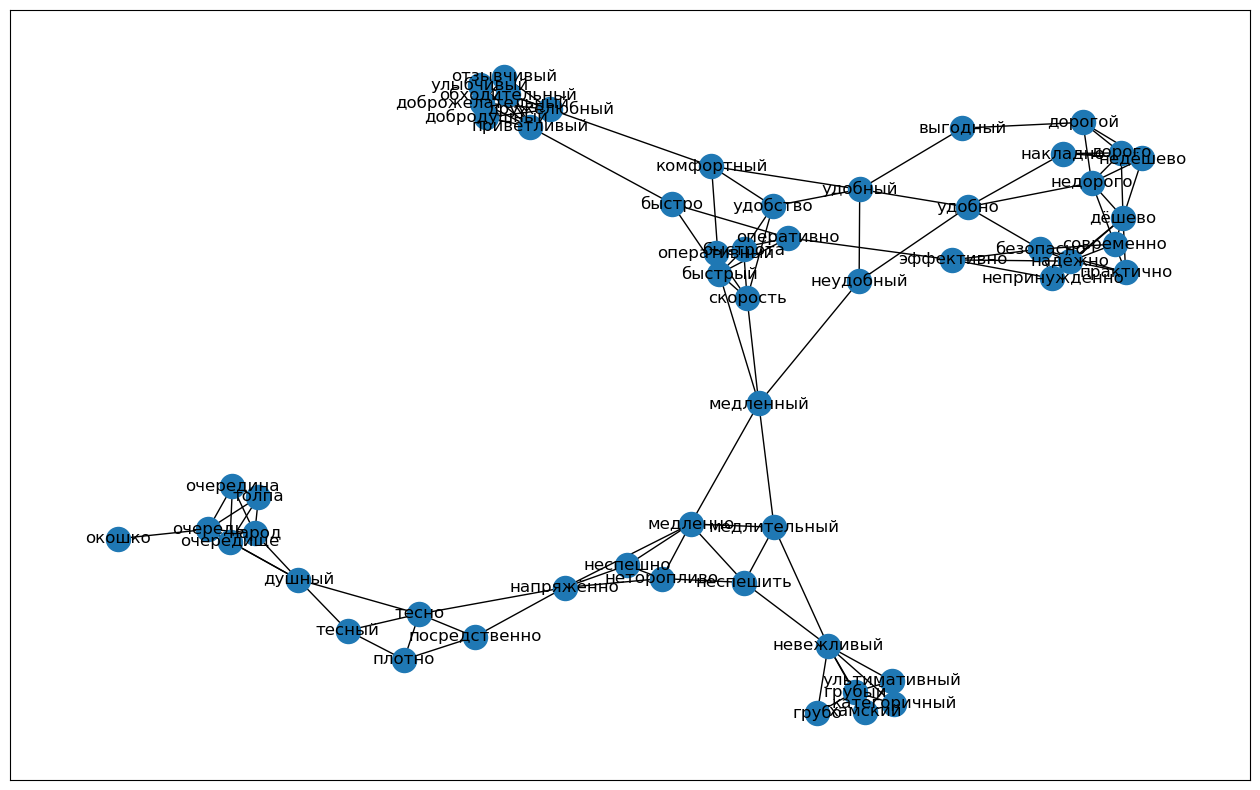

In [121]:
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(16, 10))
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

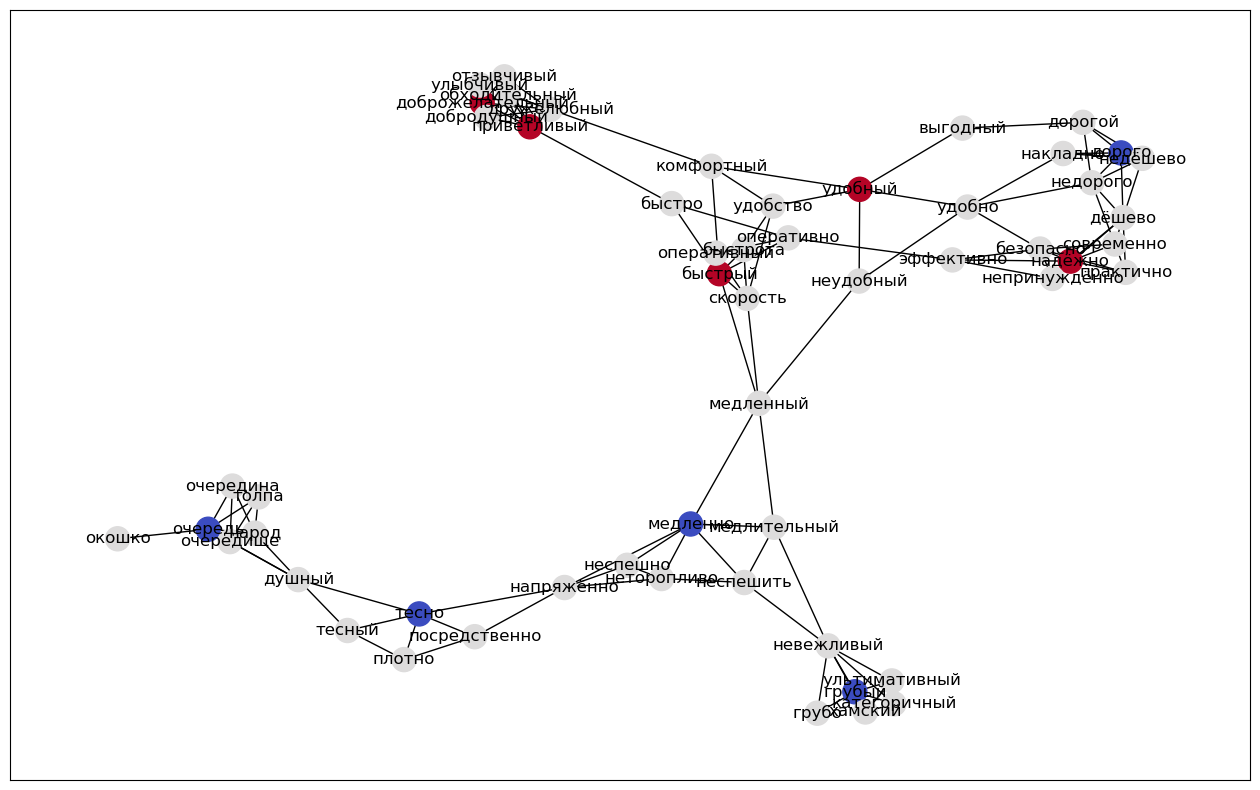

In [122]:
known_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])
unknown_y = np.array([0 for i in range(len(unknown_words))])

init_labels = dict(zip(np.append(poz_words + neg_words, list(unknown_words)), np.append(known_y, unknown_y)))
init_colors = [init_labels[i] for i in list(G.nodes)]

plt.figure(figsize=(16, 10))
nx.draw_networkx(G, pos=pos, node_color=init_colors, cmap='coolwarm')

In [159]:
def label_propagation(G, Y_init, known_nodes, unknown_nodes, threshold=0.001):
    # Расположим узлы таким образом, чтобы узлы с известными метками были первыми
    ordered_nodes = list(known_nodes) + list(unknown_nodes) 
    
    # Вычислим матрицы смежности
    A = nx.to_numpy_array(G, nodelist=ordered_nodes)
    
    # Вычислим матрицу переходов
    T = A / A.sum(axis=1, keepdims=True)
    
    # Сделаем известные узлы поглощающими
    T[:len(known_nodes), :] = 0
    T[:len(known_nodes), :len(known_nodes)] = np.identity(len(known_nodes)) 
    
    # Обновим метки, умножив известные метки на полученную матрицу переходов. 
    # Повторим, пока метки не перестанут меняться
    labels = [Y_init] # последовательность надписей для визуализации
    Y1 = Y_init 
    for i in tqdm(range(100)):
        Y0 = Y1
        Y1 = np.dot(T, Y0) # обновление вероятности переходов 
        diff = np.abs(Y0 - Y1).sum() # вычисление разницы между Y(t-1) и Y(t)
        Y1[:len(known_nodes)] = Y_init[:len(known_nodes)] # верните известные метки к их исходным значениям
        labels.append(Y1)
        if i % 10 == 0:
            print('Total difference:', diff)
        if diff < threshold:
            break
    
    return labels

 19%|████████████████▉                                                                        | 19/100 [00:00<?, ?it/s]


Total difference: 14.418650860164664
Total difference: 0.2282654239463167


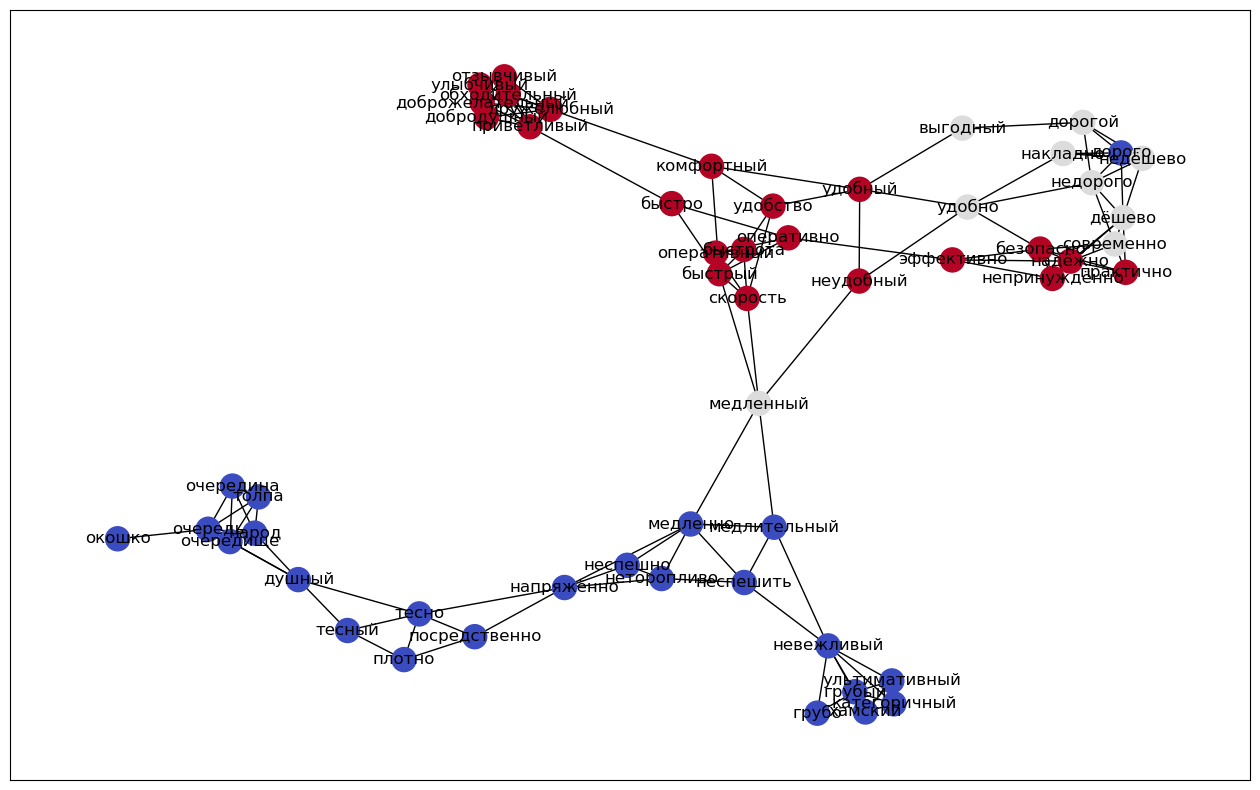

In [164]:
Y_init = np.append(known_y, unknown_y) 
labels = label_propagation(G, Y_init, poz_words + neg_words, unknown_words, threshold=0.01)

plt.figure(figsize=(16, 10))
propagated_labels = dict(zip(np.append(poz_words + neg_words, list(unknown_words)), labels[-1]))
propagated_colors = [round(propagated_labels[i]) for i in list(G.nodes)]
nx.draw_networkx(G, pos=pos, node_color=propagated_colors,  cmap='coolwarm')